**The QOSF screening task challenge**

Build a ZNE function

1. Build a simple noise model with depolarising noise
2. Create different circuits to test your noise model. Choose an observable to measure. 
3. Apply the unitary folding method
4. Apply an extrapolation method to get the zero-noise limit. Try linear, polynomial, and exponential
5. Compare your noise mitigated and unmitigated results
6. Run your ZNE function on real quantum hardware

**Introduction**

This Jupyter notebook contains code that achieves these points with comments/explanations. The subtasks (i.e., 1., 2., ...) will be clearly highlighted. 

The ZNE function here is a **local gate-based unitary folding**, wherein all gates are folded $\lambda$ times.

# Contents: 

## Section A: Circuit and simulation preliminaries

Importing libraries and setting parameters for simulation

## Section B: Creating the original circuit

We create a random 3-qubit circuit

*Corresponds to subtask 2.* 

## Section C: Perform a density matrix simulation to obtain the ideal `noiseless' result

We state that the observable is the expectation value of the generalised n-qubit '|0>' state. If numqubits = 3, then we seek the expectation value of |000>. 

For this random circuit, the ideal expectation value in the case of a noiseless simulation to obtain '|0>' is unknown in general and must be obtained from running a simulation or from analytical calculation. 

## Section D: Create a noise model

For this task, we create a depolarising channel for each gate on all qubits with probability 'depolarising_prob' 

*Corresponds to subtask 1.*

## Section E: Perform a series of noisy simulations using that noise model

We create the method 'generate_gate_folded_circuit' to generate a $\lambda$-times folded circuit. This uses **local gate-based folding**.

$\lambda$ takes on the only odd integer values for now, for simplicity. The expectation value is stored in 'measured_values_array'.

*Corresponds to subtask 3.* 

## Section F: Perform linear, polynomial, and exponential extrapolation

By default, the polynomial result is Richardson extrapolation, which fits a polynomial one order lower than the number of available datapoints. Any general polynomial fit is possible. Be aware that high-order polynomial fitting can lead to 'overfitting' if the underlying data are noisy and there are too many data points. 

This will plot the 'ideal' result, the noisy results, the fits, and the extrapolated noise-free result on a figure. 

*Corresponds to subtasks 4 and 5*

## Section A: Circuit and simulation preliminaries

Importing libraries and setting parameters for simulation

In [1]:
import qiskit
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit # Used for manual inversion 
from qiskit_aer import AerSimulator # This is the simulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, depolarizing_error # This is the noise model
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator
from qiskit import transpile
from qiskit.visualization import plot_distribution # For visualisation
import numpy as np # For arrays
from scipy.optimize import curve_fit # For curve-fitting
import matplotlib.pyplot as plt # For showing the ZNE plots

In [2]:
## Overall ZNE parameters

## Circuit parameters
numqubits = 3 # number of qubits in the quantum circuit

## Simulation parameters
numshots = 10000 # The simulator will run 10,000 shots, for example, to build the expectation value

## Observable is |0> for n qubits. 
# This method creates a string of "0" n times. Will use this to extract the observable of interest. 
target_value = ""
for index in range(numqubits):
    target_value += "0"
print("Will read the expectation value of \"|" + target_value + ">\"")

Will read the expectation value of "|000>"


## Section B: Creating the original circuit

We create a random 3-qubit circuit

*Corresponds to subtask 2.*

In [3]:
## Defining a quantum circuit consisting of
## only a barrier for aesthetic convenience

q0 = QuantumRegister(numqubits, name = 'q0')
qc0 = QuantumCircuit(q0, name = 'qc0') # exists solely to add barriers. 

qc0.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q0'), 0), Qubit(QuantumRegister(3, 'q0'), 1), Qubit(QuantumRegister(3, 'q0'), 2)), clbits=())

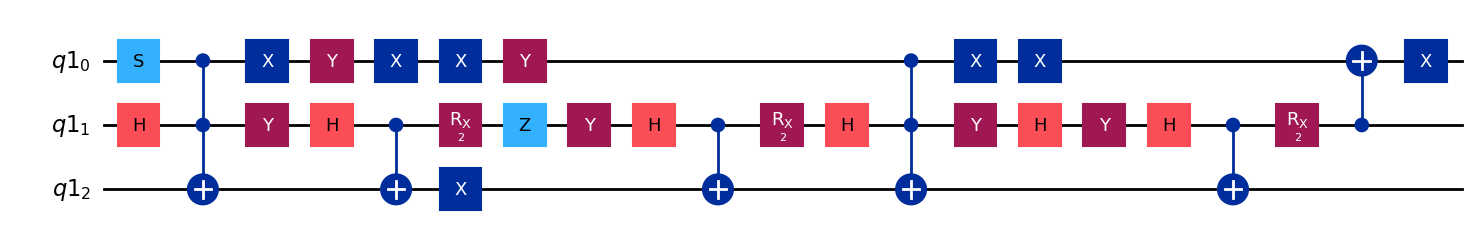

In [33]:
q1 = QuantumRegister(numqubits, name='q1')
original_circuit = QuantumCircuit(q1, name = 'qc1')

# Generate a random circuit
original_circuit.s(0)
original_circuit.h(1)
original_circuit.ccx(0,1,2)
original_circuit.y(1)
original_circuit.h(1)
original_circuit.x(0)
original_circuit.cx(1,2)
original_circuit.rx(2,1)
original_circuit.y(0)
original_circuit.x(0)
original_circuit.z(1)
original_circuit.x(2)
original_circuit.y(1)
original_circuit.h(1)
original_circuit.x(0)
original_circuit.cx(1,2)
original_circuit.rx(2,1)
original_circuit.y(0)
original_circuit.h(1)
original_circuit.ccx(0,1,2)
original_circuit.y(1)
original_circuit.h(1)
original_circuit.y(1)
original_circuit.h(1)
original_circuit.x(0)
original_circuit.x(0)
original_circuit.cx(1,2)
original_circuit.rx(2,1)
original_circuit.cx(1,0)
original_circuit.x(0)
original_circuit.draw('mpl')

# Expectation value of |000> is generally unknown without working it out analytically or running a simulation. 

## Section C: Perform a density matrix simulation to obtain the ideal `noiseless' result

We state that the observable is the expectation value of the generalised n-qubit '|0>' state. If numqubits = 3, then we seek the expectation value of |000>. 

For this random circuit, the ideal expectation value in the case of a noiseless simulation to obtain '|0>' is unknown in general and must be obtained from running a simulation or from analytical calculation. 

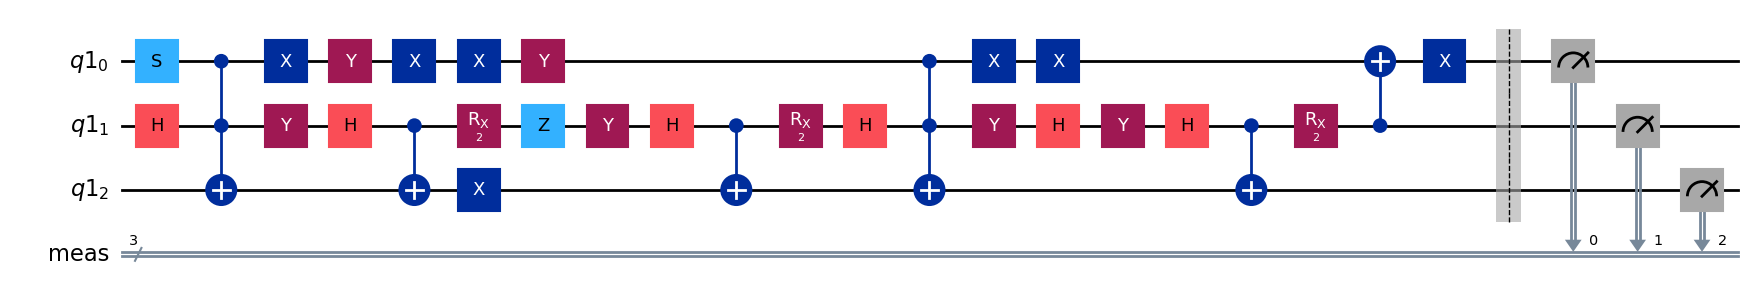

In [34]:
q_ideal = QuantumRegister(numqubits, name = 'q_ideal')
qc_ideal = QuantumCircuit(q_ideal, name = 'q_ideal')
qc_ideal = original_circuit.copy() # deep copy to q_ideal.
qc_ideal.measure_all()
qc_ideal.draw('mpl')

In [35]:
# Construct an ideal (i.e., noiseless) simulator
sim_ideal = AerSimulator(method='density_matrix')

# Perform an ideal (i.e., noiseless) simulation
result = sim_ideal.run(transpile(qc_ideal, sim_ideal), shots = numshots).result()
counts = result.get_counts(0)
plot_distribution(counts, title='Ideal counts for my circuit')

ideal_val = result.get_counts(0)[target_value]
print("Noise-less probability of observing the state |" + target_value + "> is: " + str(ideal_val/numshots))

Noise-less probability of observing the state |000> is: 0.4583


## Section D: Create a noise model

For this task, we create a depolarising channel for each gate on all qubits with probability 'depolarising_prob' 

*Corresponds to subtask 1.*

In [36]:
# Find all unique gates in original_circuit
gate_list = [];
for gate in original_circuit.decompose().data:
    word = gate[0].name
    if word not in gate_list:
        if word == 'measure':
            continue
        gate_list.append(word)
print(gate_list)

['u1', 'u2', 'h', 'cx', 'tdg', 't', 'u3', 'r']


In [37]:
## Create a simple depolarising noise model
# All gates suffer from depolarising noise uniformly
noise_model = NoiseModel()

depolarising_prob = 0.01; # Probability of depolarising noise occurring for each gate for each qubit. 

In [38]:
# Add depolarizing error to all single qubit gates
error = depolarizing_error(depolarising_prob, 1)
cx_error = depolarizing_error(depolarising_prob, 2) # CNOT errors
ccx_error = depolarizing_error(depolarising_prob, 3) # CCNOT errors

for gate in gate_list:
    if gate == 'cx' or gate == 'cz' or gate =='dcx' or gate == 'swap':
        noise_model.add_all_qubit_quantum_error(cx_error, ["cx"])
        continue;
    if gate == 'ccx':
        noise_model.add_all_qubit_quantum_error(ccx_error, ["ccx"])
        continue;
    noise_model.add_all_qubit_quantum_error(error, [gate])

print(noise_model)


NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'r', 'rz', 'sx', 't', 'tdg', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'tdg', 't', 'u3', 'u2', 'r', 'h', 'u1']
  All-qubits errors: ['u1', 'u2', 'h', 'cx', 'tdg', 't', 'u3', 'r']


## Section E: Perform a series of noisy simulations using that noise model

We create the method 'generate_gate_folded_circuit' to generate a $\lambda$-times folded circuit. This uses **local gate-based folding**.

$\lambda$ takes on the only odd integer values for now, for simplicity. The expectation value is stored in 'measured_values_array'.

*Corresponds to subtask 3.* 

In [39]:
def generate_gate_folded_circuit(lambda_value,original_circuit, final_circuit, barrier_circuit):

    if not(isinstance(lambda_value, int)):
        print("Lambda_value is not an integer. Please enter an integer. ")
        return final_circuit;
    if not(lambda_value % 2):
        print("Lambda_value is not an odd integer. Please enter an odd integer. ")
        return final_circuit;
    if lambda_value == 1:
        final_circuit = original_circuit.copy() # The "folded" circuit is just the original.
        final_circuit.measure_all(); # We assume that the final_circuit object is empty. 
        return final_circuit;
    
    ## Decompose the original circuit into layers
    dag = circuit_to_dag(original_circuit)
    numlayers = len(list(dag.layers())) # Number of layers in the original circuit
    temp = list(dag.layers())
    
    for temp2 in temp:
        ## Insert the original layer, then insert (lambda-1)/2 inverse-original pairs of that layer
        layer_as_circuit_original = dag_to_circuit(temp2['graph']) # The original layer
        
        layer_as_circuit_inverse = dag_to_circuit(temp2['graph']).inverse() # The inverse of that layer

        # Insert the original layer. 
        final_circuit = final_circuit.compose(layer_as_circuit_original)

        # Insert (lambda-1)/2 inverse-original pairs of that layer
        for index in range(round((lambda_value-1)/2)):
            final_circuit = final_circuit.compose(layer_as_circuit_inverse)
            final_circuit = final_circuit.compose(layer_as_circuit_original)
            
    
    final_circuit.measure_all()
    return final_circuit;

In [40]:
## Perform a series of at least 2 noisy simulations. 
lambda_value_array = [1, 3,5];
measured_values_array = [];
#measured_values_array.append(ideal_val/numshots)

for value in lambda_value_array:
    q3 = QuantumRegister(numqubits, name='q3')
    qc3 = QuantumCircuit(q3, name = 'qc3')
    qc3 = generate_gate_folded_circuit(value, original_circuit, qc3, qc0)
    
    # Perform a noisy simulation
    sim_noisy = AerSimulator(noise_model=noise_model, method='density_matrix')
    
    result = sim_noisy.run(transpile(qc3, sim_noisy), shots = numshots).result()
    counts = result.get_counts(0)
    #plot_distribution(counts, title='Noisy counts for my circuit')
    noisy_val = result.get_counts(0)[target_value]
    print("Probability of observing the state |" + target_value + "> is: " + str(noisy_val/numshots))
    measured_values_array.append(noisy_val/numshots)
    

Probability of observing the state |000> is: 0.3878
Probability of observing the state |000> is: 0.3077
Probability of observing the state |000> is: 0.265


## Section F: Perform linear, polynomial, and exponential extrapolation

By default, the polynomial result is Richardson extrapolation, which fits a polynomial one order lower than the number of available datapoints. Any general polynomial fit is possible. Be aware that high-order polynomial fitting can lead to 'overfitting' if the underlying data are noisy and there are too many data points. 

This will plot the 'ideal' result, the noisy results, the fits, and the extrapolated noise-free result on a figure. 

*Corresponds to subtasks 4 and 5*

In [41]:
## Curve fitting an exponential function
def exp_func(x, a, b, c):
    return a + b * np.exp(-c * x)

In [42]:
## Data processing part

lambda_vals_tot = np.array(lambda_value_array)
measured_vals_tot = np.array(measured_values_array)

# Interrogation domain
xp = np.linspace(0,np.amax(lambda_vals_tot),100)

# Polynomial fit
linfit = np.polyfit(lambda_vals_tot, measured_vals_tot, 1)
p_p = np.poly1d(linfit)
error_mitigated_value_polynomial = p_p(0)

# Richardson extrapolation fit
REfit = np.polyfit(lambda_vals_tot, measured_vals_tot, len(measured_vals_tot)-1)
p_RE = np.poly1d(REfit)
error_mitigated_value_RE = p_RE(0)

# Exponential fit
popt, pcov = curve_fit(exp_func, lambda_vals_tot, measured_vals_tot)
error_mitigated_value_exp = exp_func(0, *popt)

C:\Users\DavidRen\AppData\Local\Temp\ipykernel_20028\1598690730.py:20: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(exp_func, lambda_vals_tot, measured_vals_tot)


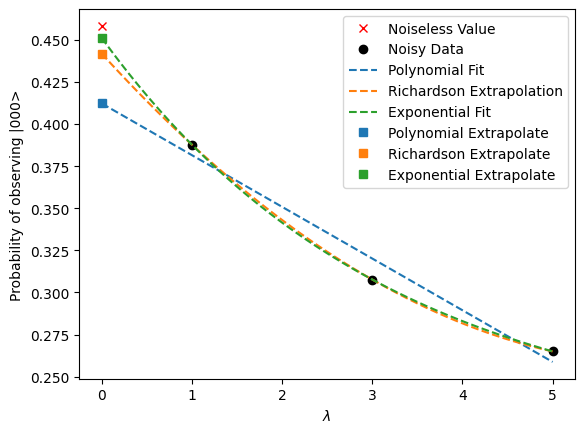

In [44]:
## Plot the ideal data, noisy data, fitted curves, and extrapolated values
plt.figure()
cmap = plt.get_cmap("tab10")
plt.plot([0], ideal_val/numshots, 'rx', label="Noiseless Value", zorder=1000) # Ideal value, without noise. 
plt.plot(lambda_vals_tot, measured_vals_tot, 'ko', label="Noisy Data")
plt.plot(xp, p_p(xp), '--', label="Polynomial Fit")
plt.plot(xp, p_RE(xp), '--', label="Richardson Extrapolation")
plt.plot(xp, exp_func(xp, *popt), '--', label="Exponential Fit") # Exponential fit

plt.plot(0, p_p(0), 's', color=cmap(0), label="Polynomial Extrapolate")
plt.plot(0, p_RE(0), 's', color=cmap(1), label="Richardson Extrapolate")
plt.plot(0, exp_func(0, *popt), 's', color=cmap(2), label="Exponential Extrapolate") # Exponential extrapolate
plt.xlabel('$\\lambda$')
plt.ylabel('Probability of observing |' +target_value +'>')
plt.legend()
plt.savefig("ZNE_gate_folding.png", dpi=300)
#plt.plot([0],ideal_val/numshots, 'x', lambda_vals_tot, measured_vals_tot, '.', xp, p(xp), '--')

By inspection of the above figure, we observe that Exponential extrapolation yields the closest error-mitigated estimate of the probability of observing |00>. The true value is 1. 

In [48]:
## Print the ZNE values
print("Using linear extrapolation, the probability is: " + str(p_p(0)))
print("Using Richardson extrapolation, the probability is: " + str(p_RE(0)))
print("Using exponential extrapolation, the probability is: " + str(exp_func(0, *popt)))
print("The true value is " + str(ideal_val/numshots))

Using linear extrapolation, the probability is: 0.4122666666666666
Using Richardson extrapolation, the probability is: 0.44187499999999963
Using exponential extrapolation, the probability is: 0.45120991349903583
The true value is 0.4583
